In [129]:
#Import Libraries
from matplotlib import pyplot as plt
import sklearn
import pandas as pd
import numpy as np
import xgboost as xgb

In [130]:
#Import Datasets

train_dataset = pd.read_csv("dataset/train.csv")
test_dataset = pd.read_csv("dataset/test.csv")

In [131]:
# Combine the 2 datasets for preprocessing 
def combined_dataset(train_data, test_data):
    train_data = train_data.drop(["Survived"], axis=1)
    combined = train_data.append(test_data)
    combined.reset_index().drop(["index"], axis=1)
    combined = combined.drop(["PassengerId"], axis=1)
    return combined

data = combined_dataset(train_dataset, test_dataset)

In [132]:
# Process Pclass
def process_Pclass(data):
    if not data.Pclass.isnull().any():
        one_hot_pclass = pd.DataFrame(pd.get_dummies(data["Pclass"], prefix="Pclass_"))
        data = pd.concat([data, one_hot_pclass], axis=1)
        data = data.reset_index().drop(["index"], axis=1)
        return data
    else:
        print("null data in Pclass")
           
data = process_Pclass(data)

In [133]:
# Process Sex
data['Sex'].replace(to_replace=dict(female=0, male=1), inplace=True)

In [134]:
# Process Titles
Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}

def process_Titles(data):
    global Title_Dictionary
    
    data['title'] = data['Name'].map(lambda x: x.split(',')[1].split('.')[0].strip())
    data['title'] = data.title.map(Title_Dictionary)
    one_hot_title = pd.DataFrame(pd.get_dummies(data["title"], prefix="title_"))
    data = pd.concat([data, one_hot_title], axis=1)
    return data

data = process_Titles(data)
    

In [135]:
# Process age
grouped_train = data.iloc[:891].groupby(['Sex','Pclass','title'])
grouped_median_train = grouped_train.median()
grouped_median_train = grouped_median_train.reset_index()[['Sex', 'Pclass', 'title', 'Age']]

def fill_age(row):
    condition = (
        (grouped_median_train['Sex'] == row['Sex']) & 
        (grouped_median_train['title'] == row['title']) & 
        (grouped_median_train['Pclass'] == row['Pclass'])
    ) 
    return grouped_median_train[condition]['Age'].values[0]

def group_age(data):
    data["children"] = data["Age"].map(lambda s: 1 if s < 18 else 0)
    data["young_adults"] = data["Age"].map(lambda s: 1 if s >= 18 and s < 36 else 0)
    data["middle_age"] = data["Age"].map(lambda s: 1 if s >= 36 and s < 56 else 0)
    data["old"] = data["Age"].map(lambda s: 1 if s >= 56 else 0)
    return data

def process_age(data):   

    data['Age'] = data.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)
    return group_age(data)

data = process_age(data)


In [136]:
# process embarked 
def process_Embarked(data):
    # most common is "S"
    data.Embarked.fillna('S', inplace=True)

    one_hot_embarked = pd.get_dummies(data["Embarked"], prefix="Embarked_")
    data = pd.concat([data, one_hot_embarked], axis=1)
    return data

data = process_Embarked(data)

In [137]:
def process_family(data):
    # introducing a new feature : the size of families (including the passenger)
    data['FamilySize'] = data['Parch'] + data['SibSp'] + 1
    
    # introducing other features based on the family size
    data['Singleton'] = data['FamilySize'].map(lambda s: 1 if s == 1 else 0)
    data['SmallFamily'] = data['FamilySize'].map(lambda s: 1 if 2 <= s <= 4 else 0)
    data['LargeFamily'] = data['FamilySize'].map(lambda s: 1 if 5 <= s else 0)
    
    return data

data = process_family(data)

In [138]:
# process fare
data.Fare.fillna(data.iloc[:891].Fare.mean(), inplace=True)

In [140]:
# process ticket

def process_ticket(data):
    # a function that extracts each prefix of the ticket, returns 'XXX' if no prefix (i.e the ticket is a digit)
    def cleanTicket(ticket):
        ticket = ticket.replace('.','')
        ticket = ticket.replace('/','')
        ticket = ticket.split()
        ticket = map(lambda t : t.strip(), ticket)
        ticket = list(filter(lambda t : not t.isdigit(), ticket))
        if len(ticket) > 0:
            return ticket[0]
        else: 
            return 'XXX'

    data['Ticket'] = data['Ticket'].map(cleanTicket)
    tickets_dummies = pd.get_dummies(data['Ticket'], prefix='Ticket')
    data = pd.concat([data, tickets_dummies], axis=1)

    return data

data = process_ticket(data)

In [141]:
def process_cabin(data):
  
    # replacing missing cabins with U (for Uknown)
    data.Cabin.fillna('U', inplace=True)
    
    data['Cabin'] = data['Cabin'].map(lambda c: c[0])
    cabin_dummies = pd.get_dummies(data['Cabin'], prefix='Cabin')    
    data = pd.concat([data, cabin_dummies], axis=1)

    return data

data = process_cabin(data)

In [142]:
# Drop columns that are un needed
data.drop(["Pclass", "Name", 
           "SibSp", "Parch", 
           "Ticket", "Cabin",
           "Embarked", "title",
           "Age"], axis=1, inplace=True)


In [144]:
data.head()

#combined["Age"] = combined.groupby(['Sex','Pclass','Title'])['Age'].transform(lambda x: x.fillna(x.median()))

,Sex,Age,Fare,Pclass__1,Pclass__2,Pclass__3,title__Master,title__Miss,title__Mr,title__Mrs,...,Ticket_XXX,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,1,22.0,7.2500,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,38.0,71.2833,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,0,26.0,7.9250,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,35.0,53.1000,1,0,0,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0
4,1,35.0,8.0500,0,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1


In [157]:
X = data[:891]
y = train_dataset["Survived"]

In [158]:
from sklearn.ensemble import RandomForestClassifier

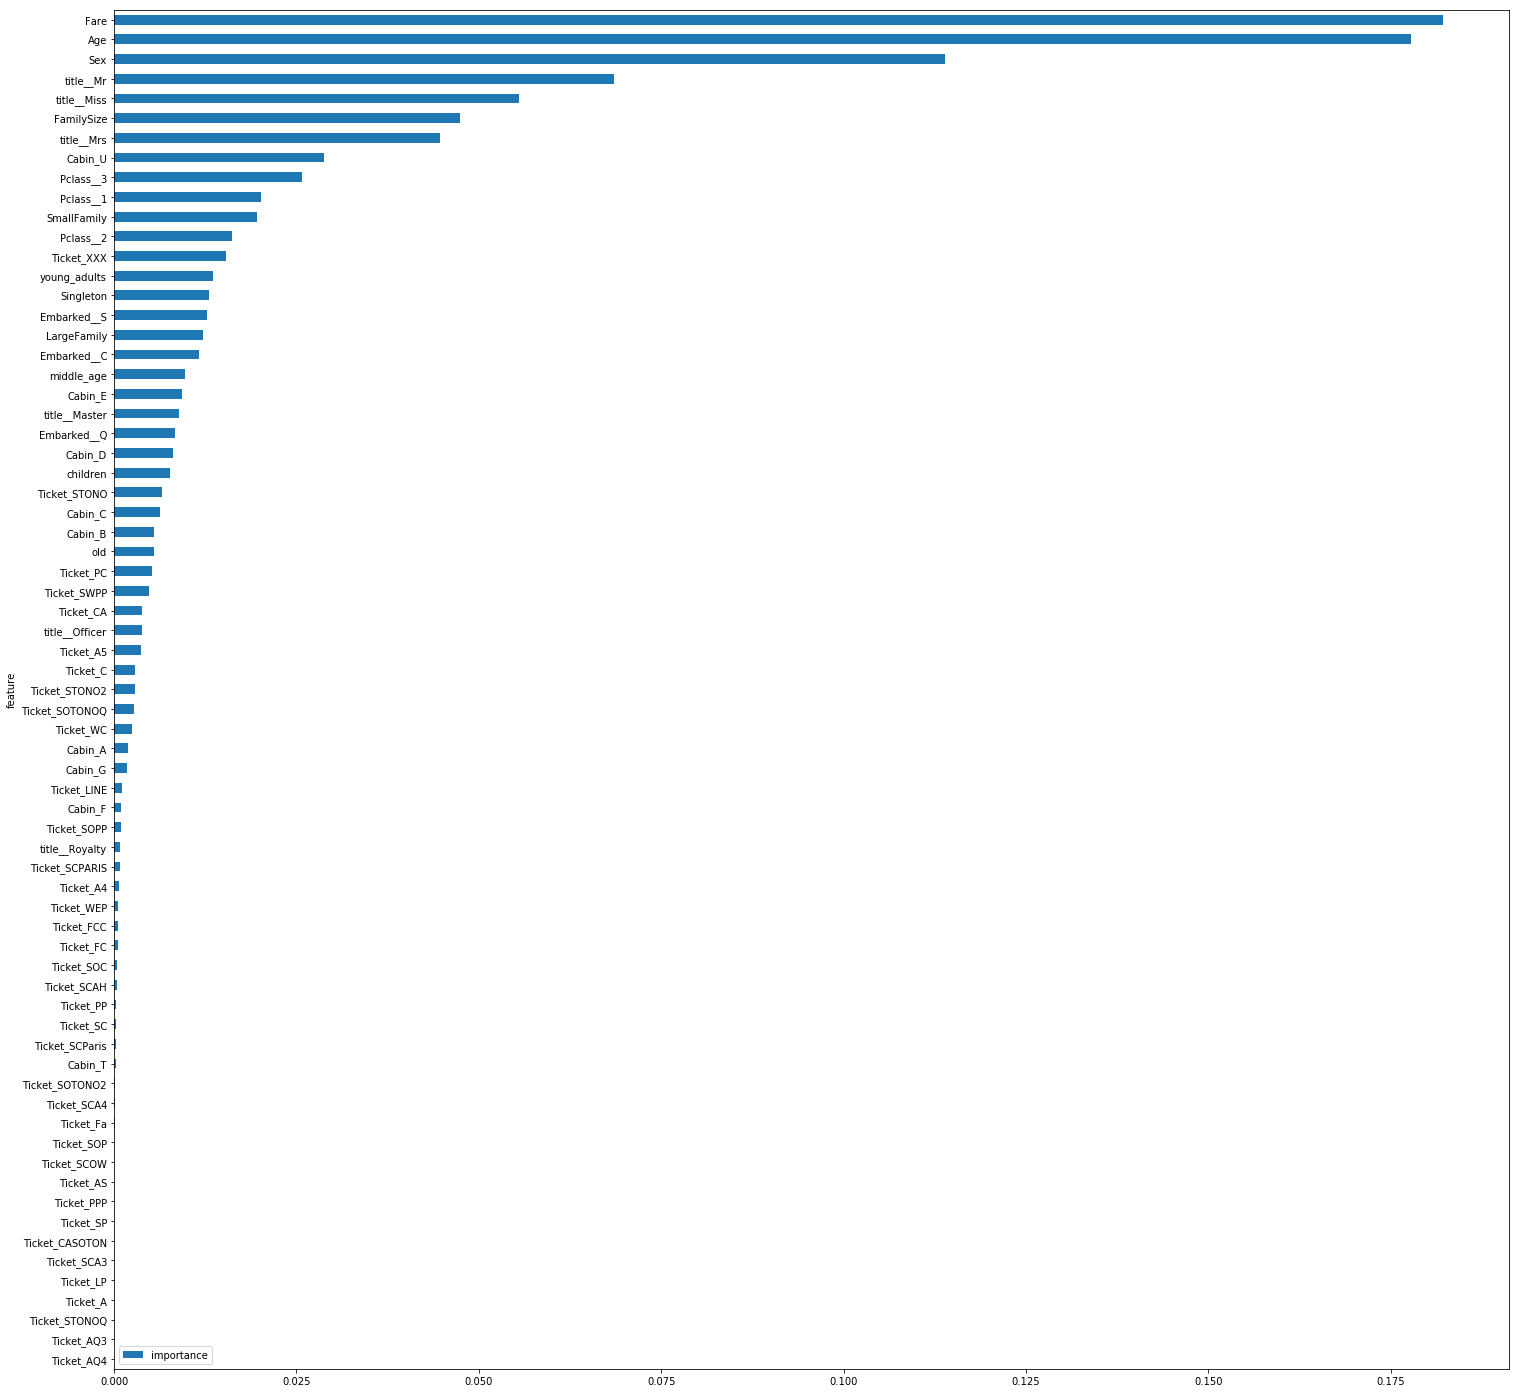

In [164]:
clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf = clf.fit(X, y)

features = pd.DataFrame()
features['feature'] = X.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='barh', figsize=(25, 25))
plt.show()

In [ ]:
sklearn.model_selection.RandomizedSearchCV
from sklearn.model_selection import KFold

 from scipy import stats
 from scipy.stats import randint
 from sklearn.model_selection import RandomizedSearchCV
 from sklearn.metrics import 
 precision_score,recall_score,accuracy_score,f1_score,roc_auc_score

In [ ]:
clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic')
param_dist = {'n_estimators': stats.randint(150, 1000),
              'learning_rate': stats.uniform(0.01, 0.6),
              'subsample': stats.uniform(0.3, 0.9),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.9),
              'min_child_weight': [1, 2, 3, 4]
             }

numFolds = 5
kfold_5 = cross_validation.KFold(n = len(X), shuffle = True, n_folds = numFolds)

clf = RandomizedSearchCV(clf_xgb, 
                         param_distributions = param_dist,
                         cv = kfold_5,  
                         n_iter = 5, # you want 5 here not 25 if I understand you correctly 
                         scoring = 'roc_auc', 
                         error_score = 0, 
                         verbose = 3, 
                         n_jobs = -1)